###Importing the necessary libraries

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
!pip install -U darts
!pip install -U optuna
!pip install -U matplotlib

In [1]:
%matplotlib inline

import torch
import random
import numpy as np
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from darts.metrics import mape as mape_darts
from darts.metrics import mase as mase_darts
from darts.metrics import mae as mae_darts
from darts.metrics import rmse as rmse_darts
from darts.metrics import smape as smape_darts
from darts.metrics import mse as mse_darts




from darts.datasets import ElectricityDataset
from darts.models import TCNModel, LinearRegressionModel, LightGBMModel, NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, rmse, mape, mae, mase
from darts.utils.likelihood_models import GaussianLikelihood
import datetime
from datetime import timedelta

import logging
from functools import reduce

In [2]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.profiler import Profiler, AdvancedProfiler
from torchmetrics import MeanAbsolutePercentageError

In [4]:
import lightgbm as lgb
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

###Defining functions

In [5]:
def select_range(df,start_date,end_date):
  """
  Parameters: df : pd.Dataframe : the dataframe that we want to check for missing datetime values
              start_date : str : the desired start date of our df
              end_date : str : the desired end_date of our df

  Returns : ts : the cut df from start_date to end_date
"""
  ts=df.copy()
  start = pd.Timestamp(start_date)
  end = pd.Timestamp(end_date)
  ts=ts.loc[start:end]
  return ts

In [6]:
def read_csv_and_set_index(file,col=None,format=None,date_parse=None, separator = None):
  """
   Parameters: file : str: the name of the csv file that we want to save as df
               col : str : the name of the column we want to set as index
            
   Returns : df : pd.DataFrame : the df from the csv file, with col as index
"""
  if (date_parse is not None):
    dateparse = lambda x: datetime.datetime.strptime(x, '%Y%m%d%H%M%S')
    parse = [col]
  else :
    parse = False
    dateparse = None

  df = pd.read_csv(file,parse_dates=parse, date_parser=dateparse,sep=separator)
  if (col is not None):
    df = df.set_index(col)
  df.index=pd.to_datetime(df.index)
  return df


In [7]:
def convert_to_timeseries(df,col=None, resolution=None):

  """"
    Parameters: df : pd.DataFrame : the df we want to convert to TimeSeries
                resolution : str : the resolution in which we want to resample
                col : [str] : the column which we want to convert to TimeSeries, if not None, inside brackets
            
   Returns : series : TimeSeries: the converted timeseries from df or df's columns ( if col is not None)
  
"""
  if(resolution is not None):
    df=df.resample(resolution).mean()

  if (col is not None):
    data = df[col]
  else :
    data = df

  series = data.squeeze()
  series = series.astype(np.float32)
  series = TimeSeries.from_series(series)
  return series

In [8]:
def split_and_scale(series,test_start_date,scaler_model=None):

  """"
    Parameters: series : TimeSeries : The timeseries we want to split into train, val test and, optionally, scale.
                val_length : int : the length of the Timeseries we want to keep as a validation set
                scaler_model : sklearn.preprocessing. : the model of scaler to be fitted in our data.
            
   Returns : train : darts.TimeSeries: the timeseries we will use as a training set, meaning the input series timeseries, but cut at the val_start_date
             val   : TimeSeries: the timeseries we will use as a validation set, meaning the input series timeseries, but startint from the val_start_date
            series_transformed : TimeSeries : The timeseries with the scaled_model fitted and transformed
"""

  if (scaler_model is not None):
    scaler = Scaler(scaler=scaler_model)
    scaler_x =scaler.fit(series)
    series_transformed = scaler_x.transform(series)       

  else : 
    scaler_x = None
    series_transformed = series
  
  train = series_transformed.drop_after(pd.Timestamp(test_start_date))
  val = series_transformed.drop_before(pd.Timestamp(pd.Timestamp(
        test_start_date) - datetime.timedelta(hours=1)))
  
  return train,val, series_transformed, scaler_x

In [9]:
def append(x, y):
    return x.append(y)


In [27]:
def backtester_final(model,
               series_transformed,
               test_start_date,
               forecast_horizon,
               stride=None,
               series=None,
               transformer_ts=None,
               retrain=False,
               future_covariates=None,
               past_covariates=None,
               path_to_save_backtest=None):
    """ Does the same job with advanced forecast but much more quickly using the darts
    bult-in historical_forecasts method. Use this for evaluation. The other only
    provides pure inference. Provide a unified timeseries test set point based
    on test_start_date. series_transformed does not need to be adjacent to
    training series. if transformer_ts=None then no inverse transform is applied
    to the model predictions.
    Parameters
    ----------
    Returns
    ----------
    """
    # produce the fewest forecasts possible.
    if stride is None:
        stride = forecast_horizon
    test_start_date = pd.Timestamp(test_start_date)
    from functools import reduce

    # produce list of forecasts
    #print("backtesting starting at", test_start_date, "series:", series_transformed)
    backtest_series_transformed = model.historical_forecasts(series_transformed,
                                                             future_covariates=future_covariates,
                                                             past_covariates=past_covariates,
                                                             start=test_start_date,
                                                             forecast_horizon=forecast_horizon,
                                                             stride=stride,
                                                             retrain=retrain,
                                                             last_points_only=False,
                                                             verbose=False)
    


    # flatten lists of forecasts due to last_points_only=False
    if isinstance(backtest_series_transformed, list):
        backtest_series_transformed = reduce(
            append, backtest_series_transformed)

    # inverse scaling
    if transformer_ts is not None:
        backtest_series = transformer_ts.inverse_transform(
            backtest_series_transformed)
        series = transformer_ts.inverse_transform(
            series_transformed)
    else:
        series = series_transformed
        backtest_series = backtest_series_transformed
        print("\nWarning: Scaler not provided. Ensure model provides normal scale predictions")
        logging.info(
            "\n Warning: Scaler not provided. Ensure model provides normal scale predictions")

    # plot all test
    fig1 = plt.figure(figsize=(15, 8))
    ax1 = fig1.add_subplot(111)
    backtest_series.plot(label='forecast')
    series \
        .drop_before(pd.Timestamp(pd.Timestamp(test_start_date) - datetime.timedelta(days=7))) \
        .drop_after(backtest_series.time_index[-1]) \
        .plot(label='actual')
    ax1.legend()
    ax1.set_title(
        f'Backtest, starting {test_start_date}, {forecast_horizon}-steps horizon')
    # plt.show()

    # plot one week (better visibility)
    forecast_start_date = pd.Timestamp(
        test_start_date + datetime.timedelta(days=7))

    fig2 = plt.figure(figsize=(15, 8))
    ax2 = fig2.add_subplot(111)
    backtest_series \
        .drop_before(pd.Timestamp(forecast_start_date)) \
        .drop_after(forecast_start_date + datetime.timedelta(days=7)) \
        .plot(label='Forecast')
    series \
        .drop_before(pd.Timestamp(forecast_start_date)) \
        .drop_after(forecast_start_date + datetime.timedelta(days=7)) \
        .plot(label='Actual')
    ax2.legend()
    ax2.set_title(
        f'Weekly forecast, Start date: {forecast_start_date}, Forecast horizon (timesteps): {forecast_horizon}, Forecast extended with backtesting...')

    # Metrics
    test_series =  series.drop_before(pd.Timestamp(pd.Timestamp(
        test_start_date) - datetime.timedelta(hours=1)))
    train_series = series.drop_after(pd.Timestamp(test_start_date))
    
    metrics = {
        
        "smape": smape_darts(
            test_series,
            backtest_series),
        "mase": mase_darts(
            test_series,
            backtest_series,
            insample=train_series),
        "mae": mae_darts(
            test_series,
            backtest_series),
        "rmse": rmse_darts(
            test_series,
            backtest_series),
        "mse" :mse_darts(
            test_series,
            backtest_series),
        "mape": mape_darts(
            test_series,
            backtest_series)
       }

    

    for key, value in metrics.items():
        print(key, ': ', value)



    return {"metrics": metrics, "eval_plot": plt, "backtest_series": backtest_series}


In [28]:
def eval_model(test_set, preds):
    
    metrics = {
        
        "mse" : mean_squared_error(test_set, preds),
        "rmse" :mean_squared_error(test_set, preds)**(0.5),
        "mape" :mean_absolute_percentage_error(test_set, preds),
        "mae" : mean_absolute_error(test_set, preds)
    }
    
    
    plt.figure(figsize=(15, 5))

    for key, value in metrics.items():
        print(key, ': ', value)


In [29]:
def drop_zeros(series, null_dates = None):

  """
  Parameters : series :Union[darts.Timeseries, series ]
  null_dates : list of datetime indexes

  This function takes a series and drops the values that are zero if null_dates = None, otherwise it drops the rows with index in the null_dates list.
  Returns: series : UJnion[darts.Timeseries, series]
          null_dates : a list containing the indexes of zero values, if null_dates (input parameter) is None 
  """

  temp = series.pd_dataframe()
  if (null_dates is None):
    null_dates = temp[temp['active_w6'] == 0].index
  temp = temp.drop(index =null_dates)
  series = temp.squeeze()
  series = series.astype(np.float32)
  return series , null_dates

In [13]:
def feature_target_split(df,col_name, lookback_window=24*3, forecast_horizon=1):# lookback_window: 168 = 7 days(* 24 hours)
    """
    
    **lookback_window**
    In a for-loop of 'lookback_window' max iterations, starting from 0 
    At N-th iteration (iter): 
        1. create a shifted version of 'Load' column by N rows (vertically) and 
        2. stores it in a column* (feature_'N')
    Same pseudo-code for 'forecast_horizon' loop
    
    *At first iterations of both loops, the new columns (feature/target) are going to be firstly created
    but for each iteration, the same columns are going to be used
    
    We store each new column created in a dictionary which, at the end, convert it to dataframe
    The reason behind this choice is that if it was initially a dataframe, for large amount of loops,
    fast insertion of new columns would cause a performance issue (slower) even though the end result
    would propably not be altered
    
    Parameters: 
        df: pandas.dataframe containing column to parse
        lookback_window: lookback_window - # feature columns - # inputs in model
        forecast_horizon: forecast_horizon - # target columns - # outputs in model
        col_name - str - the name of the column containing t-- -- - -to be filled
    ----------
    Returns
        'subset'_X: pandas.dataframe containing features of df after preprocess for model
        'subset'_Y: pandas.dataframe containing targets of df after preprocess for model
    -------
    """

    # Reset "Unnamed: 0" based on concated df 
    df['Unnamed: 0'] = range(1, len(df) + 1)

    df_copy = df.copy()    

    df_new = {}
        
    for inc in range(0,int(lookback_window)):
        df_new['feature_' + str(inc)] = df_copy[col_name].shift(-inc)

    # shift 'load' column permanently for as many shifts happened at 'lookback_window' loops  
    df_copy[col_name] = df_copy[col_name].shift(-int(lookback_window))
                    
    for inc in range(0,int(forecast_horizon)):
        df_new['target_' + str(inc)] = df_copy[col_name].shift(-inc)    
    
    df_new = pd.DataFrame(df_new, index=df_copy.index)
    df_new = df_new.dropna().reset_index(drop=True)    
                            
    return df_new.iloc[:,:lookback_window] , df_new.iloc[:,-forecast_horizon:]

##Before Forecasting

###Reading CSVs

In [14]:
power =read_csv_and_set_index('power_dt.csv','index')
current =read_csv_and_set_index('current_dt.csv','index')
voltage =read_csv_and_set_index('voltage_dt.csv','index')
weather = read_csv_and_set_index('weather.csv',col='time [UTC](yyyymmddHHMM)',date_parse = True, separator =';')

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


###Selecting range of dataframe

Based on our previous data analysis, we have a lot of whole months with missing values. In order for our forecasting models to work we will select the range from 2021-08-06 to 2022-07-03, where the missing values are very few.

In [169]:
start ='2021-08-06 17:00:00'
end = '2022-07-03 17:00:00'
power = select_range(power,start,end)
current=select_range(current,start,end)
voltage = select_range(voltage,start,end)
weather = select_range(weather,start,end)


###Interpolating

We chosse to fill the missing values with interpolation, which will take the mean of the previous and the next value of the missing one and fill the NaN value with it.

In [170]:
power = power.interpolate()
current = current.interpolate()
voltage  = voltage.interpolate()


Forecasting using Darts Library

#Historical Forecasts 

##Forecasting of the headquarter loads meter's current (W4)


###Creating the train/validation Timeseries

#####Converting our dataframe to TimeSeries

We convert the part of the dataframe that concerns us, now the phase 1 of the current measured at the headquarter loads to Timeseries, with 60 minutes resolution.

In [305]:
series = convert_to_timeseries(current,['w4_phase1'],'60min')
series=abs(series) 

#####Spliting series to train and validation series 


We will split our series to train and validation ones, by calling the custom split_and scale function, giving as a parameter the date when we want to start the testing. We start by not giving our function a scaler, as we want to test our model with non-scaled data.

As we have 11 months of data we choose to keep the 10 months for training and the one month left for validating.

In [306]:
train, val, series_transformed, scaler = split_and_scale(series, '2022-06-03 17:00:00')

### LighGBM Model without past/ covariates


First we will try the LightGBM Model without any past or future covariates and check its performance

##### Train the model and predict 

After trying many values, we choose 7 days ( 7 x 24 observations) as the lookback window. (lags = 7*24)

In [307]:
lgbm_model = LightGBMModel(lags = 7*24)
lgbm_model.fit(train)


After fitting and training the model with our data we use the backtester_final function to make historical forecasts.

This method uses an expanding training window; it repeatedly builds a training set from the beginning of series. It trains the model on the training set, emits a forecast of length equal to forecast_horizon - here one hour - and then moves the end of the training set forward by stride time steps.


smape :  8.282354701771839
mase :  0.8376697746122842
mae :  5.802240590756942
rmse :  8.891943530739253
mse :  79.06665975385566
mape :  8.364118304237646


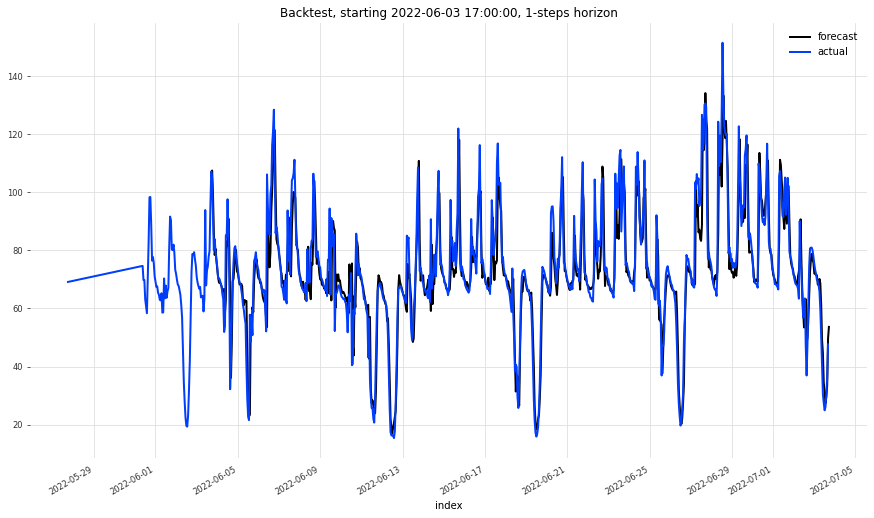

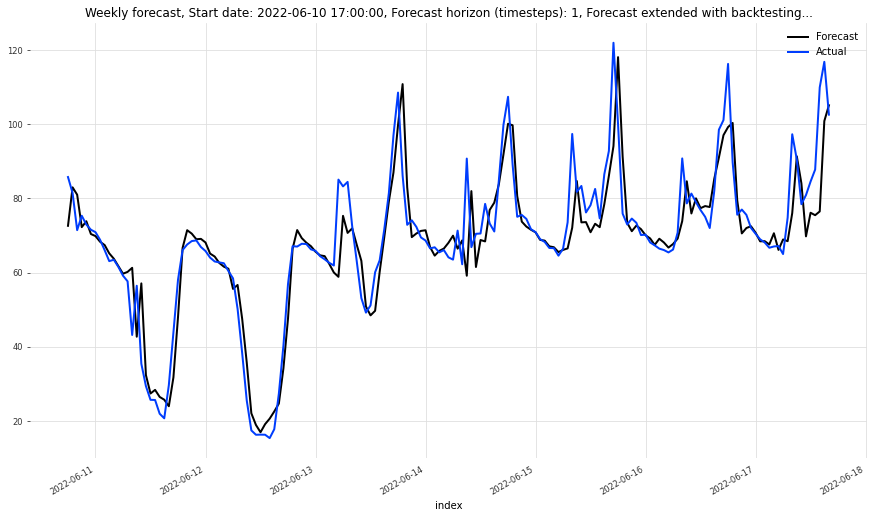

In [308]:
backtest_dict = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler )

We get a MASE error of 0.838. As MASE is defined as MAE / MAE*(Naive)* this value means that the Darts Lightgbm model performs better at forecasting the values of W4 compared to the Naive forecast.
Also we get a mean absolute percentage error of 8.364% which is not high but not too low either.

Saving the returns of the backtester function to variables

In [309]:
backtest_series = backtest_dict.get("backtest_series")

In [310]:
backtest_metrics = backtest_dict.get("metrics")

In [311]:
test_series = series.drop_before(pd.Timestamp(pd.Timestamp(pd.Timestamp(
        '2022-06-03 17:00:00') - datetime.timedelta(hours=1))))

### Adding past and/or future covariates to LightGBM


We will use the weather data and the datetime attribute as covariates

Firstly we are going to convert the weather data to timeseries

In [312]:
weather_rad=convert_to_timeseries(weather,'global radiation [W/m^2]','60min')
weather_humidity = convert_to_timeseries(weather,'relative humidity [%]','60min')
weather_temp = convert_to_timeseries(weather,'air temperature [°C]','60min')
weather_cloud = convert_to_timeseries(weather,'cloudcover [%]','60min')
weather_wind = convert_to_timeseries(weather,'wind speed[m/s]','60min')


We will take the hour of the day and month attributes and convert them to Timeseries

In [313]:
hour_covariate = convert_to_timeseries(power,['hour_of_day'],'60min')
month_covariate = convert_to_timeseries(power,['month'],'60min')

####Light GBM Model with past covariates

Using the stack function to add multiple timeseries as past covariates

In [314]:
past_covariates =(weather_temp).stack(hour_covariate).stack(weather_rad)

##### Splitting our past covariates to train, validation series

In [315]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(past_covariates,'2022-06-03 17:00:00')


We choose 7 * 24 lags as the lookback window and 1 day as lags for the past covariates.


smape :  8.177516690351668
mase :  0.8138997030780426
mae :  5.637593759653349
rmse :  8.919552690046688
mse :  79.55842019051912
mape :  8.313120094366829


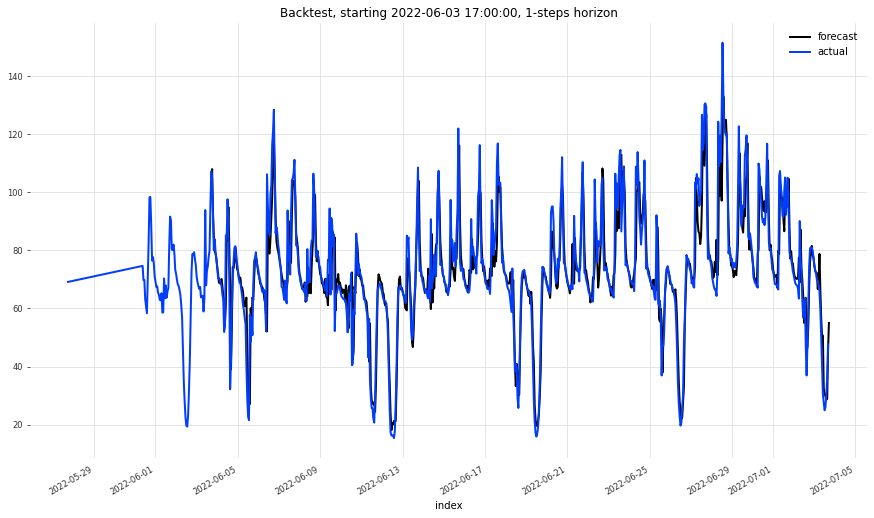

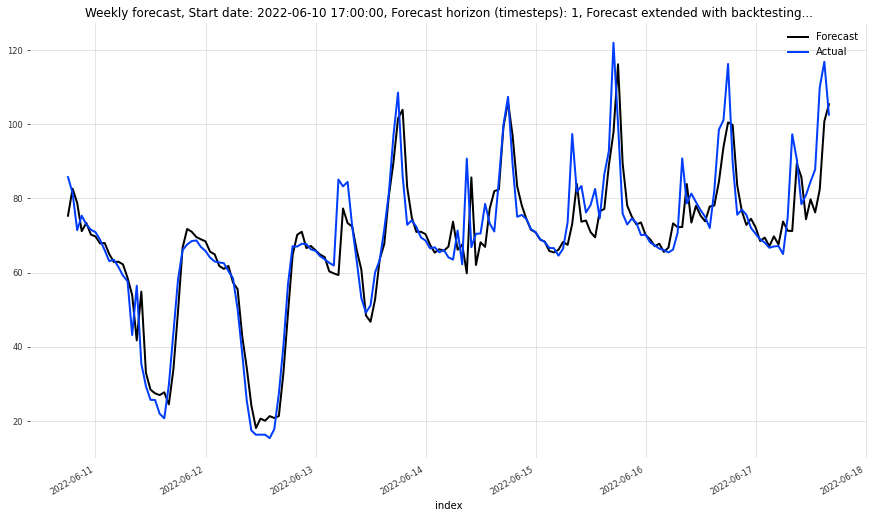

In [316]:
lgbm_model = LightGBMModel(lags = 7*24, lags_past_covariates = 1*24)
lgbm_model.fit(train, past_covariates = train_cov)
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, past_covariates=series_cov)

We notice that the model performs a little better with the addition of the past covariates as mase has reduced from 0.838 to 0.814 and MAPE from 8.364% to 8.314%. For these scores we have used as past covariates : the temperature of the air, the global radiation and the hour attribute.

####Light GBM Model with future covariates

Using the stack function to add multiple timeseries as future covariates

In [317]:
future_covariates =(weather_temp).stack(hour_covariate).stack(weather_rad)

##### Splitting our future covariates to train, validation series

In [318]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(future_covariates,'2022-06-03 17:00:00')


#####Train and predict

We will use as lags for the covariates used as past covariates 1*24 while for the future covariates we will take 1 lag to train our model

In [319]:
lgbm_model = LightGBMModel(lags = 7*24, lags_future_covariates = [1*24,1])
lgbm_model.fit(train, future_covariates = series_cov)


smape :  7.9009843798710016
mase :  0.8056525446286293
mae :  5.580468626380233
rmse :  8.84781189021782
mse :  78.28377524467982
mape :  7.868380073352068


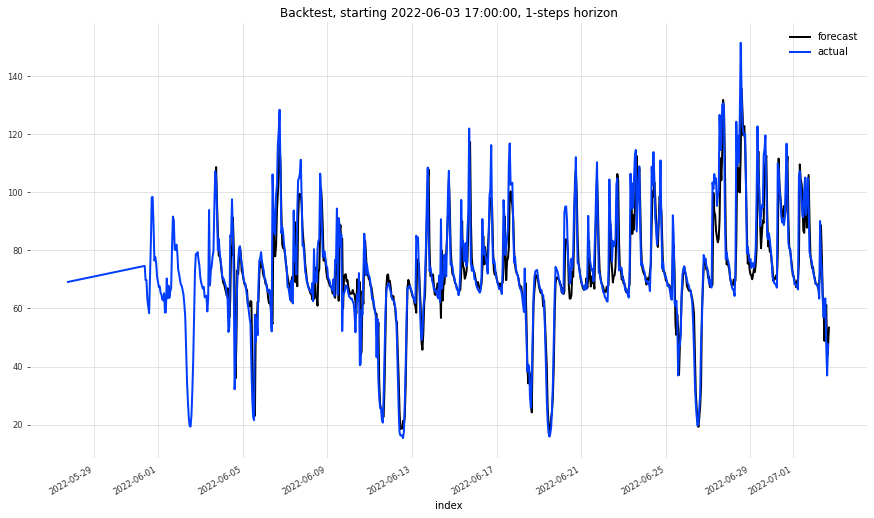

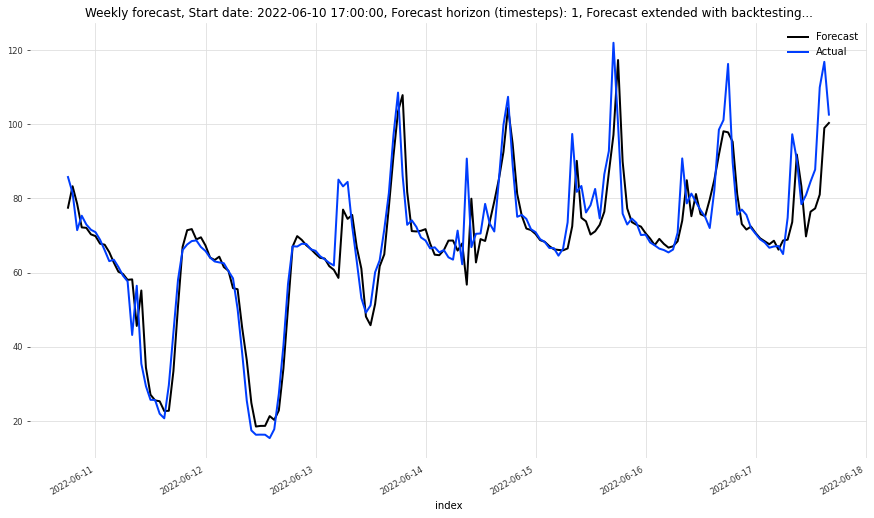

In [320]:
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, future_covariates=series_cov)

We notice that the model has a better performace when it is been trained with future covariates instead of past, as MAPE ans MASE are now 7.868% and 0.806 instead of 8.314% and 0.814 that were with the past covariate model.

###Manual creation of dataframe used for historical forecasts

In order to check the validity of the forecasts made with historical_forecasts from Darts Library, we are going to manually test it, using sklearn library's forecasting models and metrics.

In [321]:
test_df = series.pd_dataframe()

By calling the feature_target_split function we split our series to a dataset containing the feature- target values based on the lookback_window and the forecast_horizon

In [322]:
X , Y = feature_target_split(test_df,test_df.columns[0],lookback_window=7*24)

Spliting dataset to x_train, x_test, y_train and y_test

In [323]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.09062303335431088735053492762744, random_state=42)

Defining the model, training it and predicting

In [324]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

In [325]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [326]:
model = lgb.train(params,train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l2: 767.154	valid_0's l1: 21.5614
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 644.767	valid_0's l1: 19.7521
[3]	valid_0's l2: 545.019	valid_0's l1: 18.1127
[4]	valid_0's l2: 464.474	valid_0's l1: 16.6906
[5]	valid_0's l2: 398.848	valid_0's l1: 15.4114
[6]	valid_0's l2: 345.592	valid_0's l1: 14.277
[7]	valid_0's l2: 300.945	valid_0's l1: 13.2836
[8]	valid_0's l2: 263.666	valid_0's l1: 12.3797
[9]	valid_0's l2: 232.094	valid_0's l1: 11.5862
[10]	valid_0's l2: 206.725	valid_0's l1: 10.9135
[11]	valid_0's l2: 186.164	valid_0's l1: 10.3301
[12]	valid_0's l2: 168.267	valid_0's l1: 9.79735
[13]	valid_0's l2: 153.684	valid_0's l1: 9.32089
[14]	valid_0's l2: 141.803	valid_0's l1: 8.91701
[15]	valid_0's l2: 131.89	valid_0's l1: 8.54811
[16]	valid_0's l2: 123.384	valid_0's l1: 8.23122
[17]	valid_0's l2: 115.734	valid_0's l1: 7.93978
[18]	valid_0's l2: 110.407	valid_0's l1: 7.70517
[19]	valid_0's

In [327]:
y_pred = model.predict(x_test)


Checking model's performance by gathering useful metrics

In [328]:
eval_model(y_test,y_pred)

mse :  65.36203887673565
rmse :  8.084679268637418
mape :  0.06772521133032797
mae :  5.465305486148784


<Figure size 1080x360 with 0 Axes>

###Comparing Sklearn with Darts model performance

**Darts Metrics**

mse :  79.06665975385566

rmse :  8.891943530739253


mape :  8.364118304237646


mae :  5.802240590756942

**Sklearn's Metrics**

mse :  65.36203887673565

rmse :  8.084679268637418

mape :  0.06772521133032797

mae :  5.465305486148784

As we see, by comparing the two models' metrics we get a better performance by using the sklearn's light gbm as mape = 6.78% instead of 8.36% and mean squared error(mse) is 65.36 instead of 79

##Forecasting of the headquarter loads meter's voltage (W4)


###Creating the train/validation Timeseries

We are going to repeat the procedure followed before

#####Converting our dataframe to TimeSeries

We convert the part of the dataframe that concerns us, now the phase 1 of the voltage measured at the headquarter loads to Timeseries, with 60 minutes resolution.

In [329]:
series = convert_to_timeseries(voltage,['w4_u1'],'60min')
series=abs(series) 

#####Spliting series to train and validation series 


We will split our series to train and validation ones, by calling the custom split_and scale function, giving as a parameter the date when we want to start the testing. We start by not giving our function a scaler, as we want to test our model with non-scaled data.

As we have 11 months of data we choose to keep the 10 months for training and the one month left for validating.

In [330]:
train, val, series_transformed, scaler = split_and_scale(series, '2022-06-03 17:00:00')

### LighGBM Model without past/ covariates


First we will try the LightGBM Model without any past or future covariates and check its performance

##### Train the model and predict 

After trying many values, we choose 7 days ( 7 x 24 observations) as the lookback window. (lags = 7*24)

In [331]:
lgbm_model = LightGBMModel(lags = 7*24)
lgbm_model.fit(train)


After fitting and training the model with our data we use the backtester_final function to make historical forecasts.

This method uses an expanding training window; it repeatedly builds a training set from the beginning of series. It trains the model on the training set, emits a forecast of length equal to forecast_horizon - here one hour - and then moves the end of the training set forward by stride time steps.


smape :  0.3092508456821961
mase :  0.895648312647416
mae :  0.7301261258834956
rmse :  0.913206324739209
mse :  0.8339457915436936
mape :  0.30928585656528546


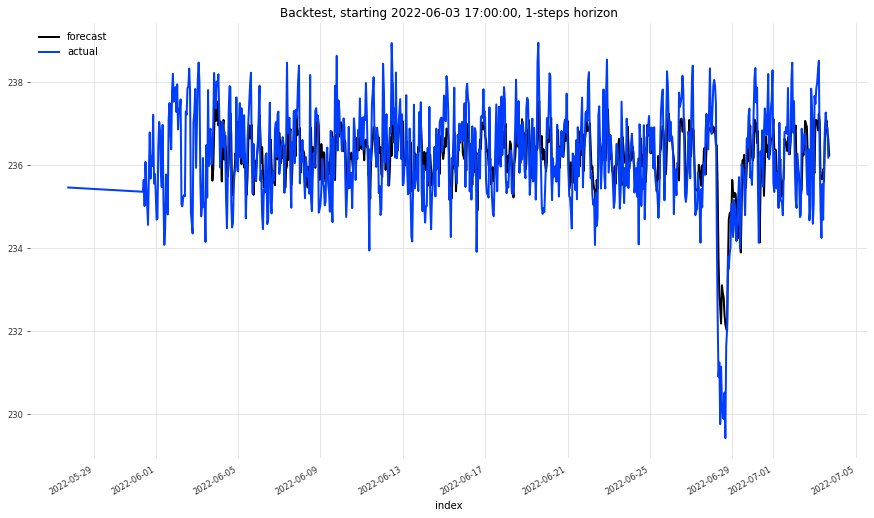

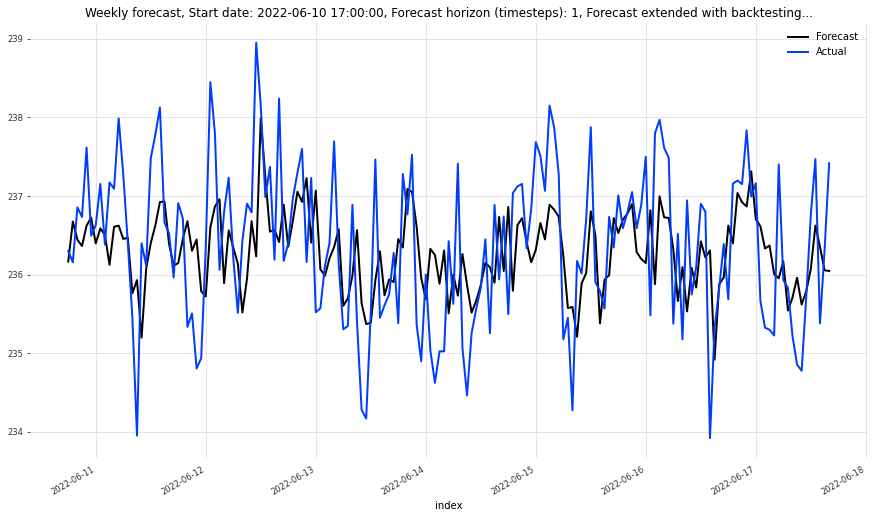

In [332]:
backtest_dict = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler )

We get a MASE error of 0.895. As MASE is defined as MAE / MAE*(Naive)* this value means that the Darts Lightgbm model performs better at forecasting the values of W4 compared to the Naive forecast.
Also we get a mean absolute percentage error of 0.309% which is not high but not too low either.

Saving the returns of the backtester function to variables in case we want to plot our data 

In [333]:
backtest_series = backtest_dict.get("backtest_series")

In [334]:
backtest_metrics = backtest_dict.get("metrics")

In [335]:
test_series = series.drop_before(pd.Timestamp(pd.Timestamp(pd.Timestamp(
        '2022-06-03 17:00:00') - datetime.timedelta(hours=1))))

### Adding past and/or future covariates to LightGBM


We will use the weather data and the datetime attribute as covariates

Firstly we are going to convert the weather data to timeseries

In [336]:
weather_rad=convert_to_timeseries(weather,'global radiation [W/m^2]','60min')
weather_humidity = convert_to_timeseries(weather,'relative humidity [%]','60min')
weather_temp = convert_to_timeseries(weather,'air temperature [°C]','60min')
weather_cloud = convert_to_timeseries(weather,'cloudcover [%]','60min')
weather_wind = convert_to_timeseries(weather,'wind speed[m/s]','60min')


We will take the hour of the day and month attributes and convert them to Timeseries

In [337]:
hour_covariate = convert_to_timeseries(power,['hour_of_day'],'60min')
month_covariate = convert_to_timeseries(power,['month'],'60min')

####Light GBM Model with past covariates

Using the stack function to add multiple timeseries as past covariates

In [341]:
past_covariates =(weather_temp).stack(hour_covariate)

##### Splitting our past covariates to train, validation series

In [342]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(past_covariates,'2022-06-03 17:00:00')


We choose 7 * 24 lags as the lookback window and 1 day as lags for the past covariates.


smape :  0.30897251343643917
mase :  0.8946103598831974
mae :  0.7292799941821485
rmse :  0.9327633897392975
mse :  0.8700475412379447
mape :  0.3091172085958815


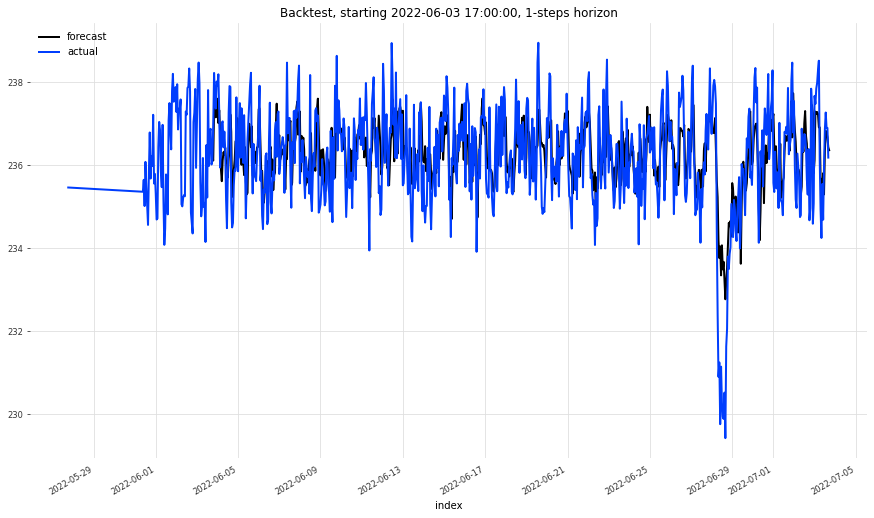

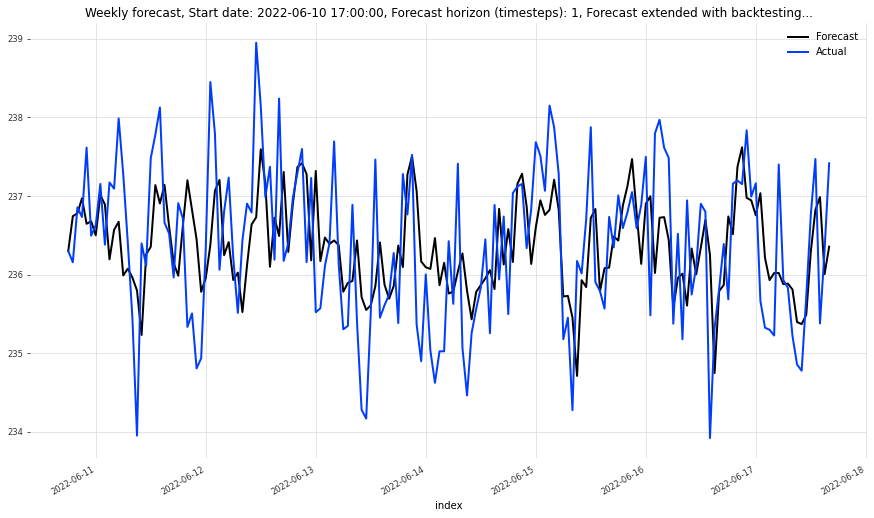

In [343]:
lgbm_model = LightGBMModel(lags = 7*24, lags_past_covariates = 1*24)
lgbm_model.fit(train, past_covariates = train_cov)
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, past_covariates=series_cov)

We notice that the model doesn't perform better with the addition of the past covariates

####Light GBM Model with future covariates

Using the stack function to add multiple timeseries as future covariates

In [344]:
future_covariates =(weather_temp).stack(hour_covariate).stack(weather_rad)

##### Splitting our future covariates to train, validation series

In [345]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(future_covariates,'2022-06-03 17:00:00')


#####Train and predict

We will use as lags for the covariates used as past covariates 1*24 while for the future covariates we will take 1 lag to train our model

In [346]:
lgbm_model = LightGBMModel(lags = 7*24, lags_future_covariates = [1*24,1])
lgbm_model.fit(train, future_covariates = series_cov)


smape :  0.3091835729075968
mase :  0.8953988231974953
mae :  0.7299227438607226
rmse :  0.9117806138425664
mse :  0.8313438877791272
mape :  0.30926485454818275


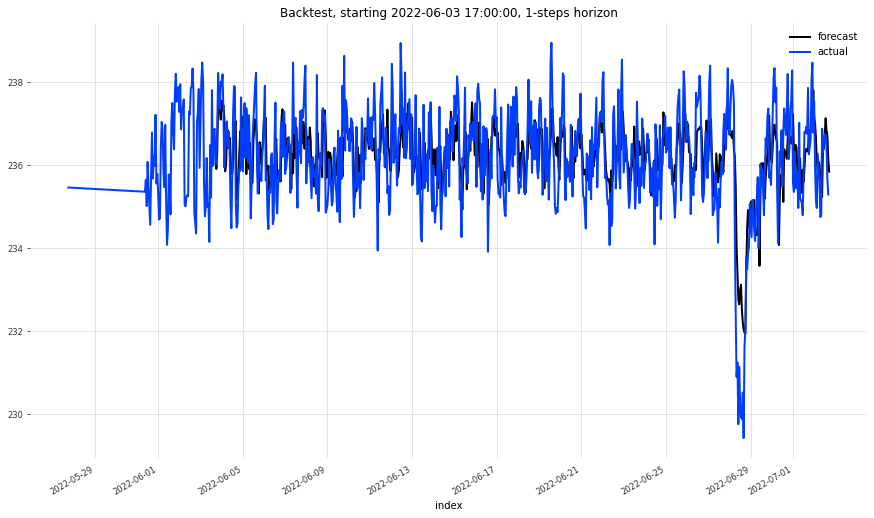

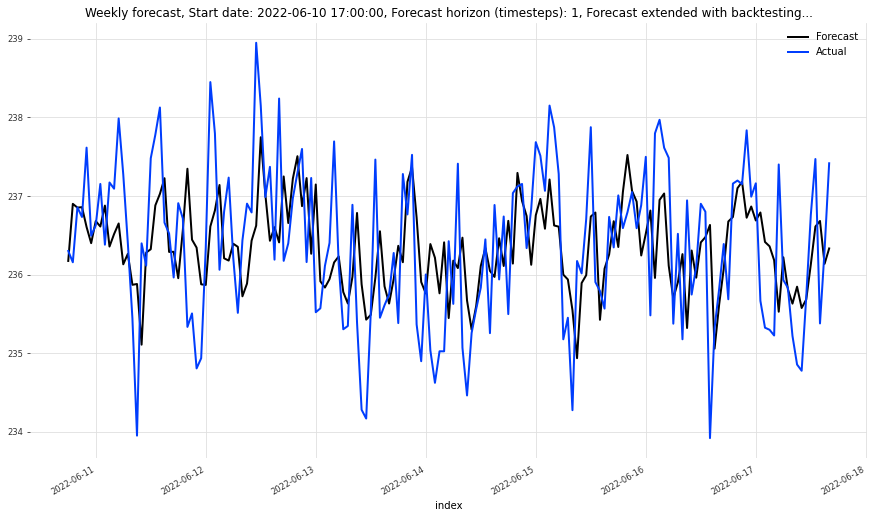

In [347]:
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, future_covariates=series_cov)

We notice that the model has the same performance as before so adding the future covariates doesn't make the model better.

###Manual creation of dataframe used for historical forecasts

In order to check the validity of the forecasts made with historical_forecasts from Darts Library, we are going to manually test it, using sklearn library's forecasting models and metrics.

In [348]:
test_df = series.pd_dataframe()

By calling the feature_target_split function we split our series to a dataset containing the feature- target values based on the lookback_window and the forecast_horizon

In [349]:
X , Y = feature_target_split(test_df,test_df.columns[0],lookback_window=7*24)

Spliting dataset to x_train, x_test, y_train and y_test

In [350]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.09062303335431088735053492762744, random_state=42)

Defining the model, training it and predicting

In [351]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

In [352]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [353]:
model = lgb.train(params,train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l2: 1.20386	valid_0's l1: 0.836928
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 1.12532	valid_0's l1: 0.814317
[3]	valid_0's l2: 1.0633	valid_0's l1: 0.795208
[4]	valid_0's l2: 1.01184	valid_0's l1: 0.779045
[5]	valid_0's l2: 0.971088	valid_0's l1: 0.76552
[6]	valid_0's l2: 0.937107	valid_0's l1: 0.752882
[7]	valid_0's l2: 0.908131	valid_0's l1: 0.740295
[8]	valid_0's l2: 0.885143	valid_0's l1: 0.731451
[9]	valid_0's l2: 0.866092	valid_0's l1: 0.723091
[10]	valid_0's l2: 0.849178	valid_0's l1: 0.714757
[11]	valid_0's l2: 0.833026	valid_0's l1: 0.707184
[12]	valid_0's l2: 0.820944	valid_0's l1: 0.701239
[13]	valid_0's l2: 0.811451	valid_0's l1: 0.695125
[14]	valid_0's l2: 0.803042	valid_0's l1: 0.690711
[15]	valid_0's l2: 0.795197	valid_0's l1: 0.686222
[16]	valid_0's l2: 0.788966	valid_0's l1: 0.68227
[17]	valid_0's l2: 0.783977	valid_0's l1: 0.678725
[18]	valid_0's l2: 0.779055	valid_

In [354]:
y_pred = model.predict(x_test)


Checking model's performance by gathering useful metrics

In [355]:
eval_model(y_test,y_pred)

mse :  0.7438583957439
rmse :  0.8624722579561037
mape :  0.0027679615114710203
mae :  0.6537902859759445


<Figure size 1080x360 with 0 Axes>

###Comparing Sklearn with Darts model performance

**Darts Metrics**

mse :  0.8339457915436936

rmse :  0.913206324739209

mape :  0.30928585656528546

mae :  0.7301261258834956


**Sklearn's Metrics**

mse :  0.7438583957439

rmse :  0.8624722579561037

mape :  0.0027679615114710203

mae :  0.6537902859759445

As we see, by comparing the two models' metrics we get a better performance by using the sklearn's light gbm 

##Forecasting of the headquarter loads meter's active power (W4)


###Creating the train/validation Timeseries

#####Converting our dataframe to TimeSeries

We convert the part of the dataframe that concerns us, now the active power measured at the headquarter loads to Timeseries, with 60 minutes resolution.

In [356]:
series = convert_to_timeseries(power,['active_w4'],'60min')
series=abs(series) 

#####Spliting series to train and validation series 


We will split our series to train and validation ones, by calling the custom split_and scale function, giving as a parameter the date when we want to start the testing. We start by not giving our function a scaler, as we want to test our model with non-scaled data.

As we have 11 months of data we choose to keep the 10 months for training and the one month left for validating.

In [357]:
train, val, series_transformed, scaler = split_and_scale(series, '2022-06-03 17:00:00')

### LighGBM Model without past/ covariates


First we will try the LightGBM Model without any past or future covariates and check its performance

##### Train the model and predict 

After trying many values, we choose 7 days ( 7 x 24 observations) as the lookback window. (lags = 7*24)

In [358]:
lgbm_model = LightGBMModel(lags = 7*24)
lgbm_model.fit(train)


After fitting and training the model with our data we use the backtester_final function to make historical forecasts.

This method uses an expanding training window; it repeatedly builds a training set from the beginning of series. It trains the model on the training set, emits a forecast of length equal to forecast_horizon - here one hour - and then moves the end of the training set forward by stride time steps.


smape :  10.002943839071408
mase :  0.851445153029391
mae :  4.158803484572047
rmse :  6.314793433720111
mse :  39.87661611055463
mape :  11.508438291964119


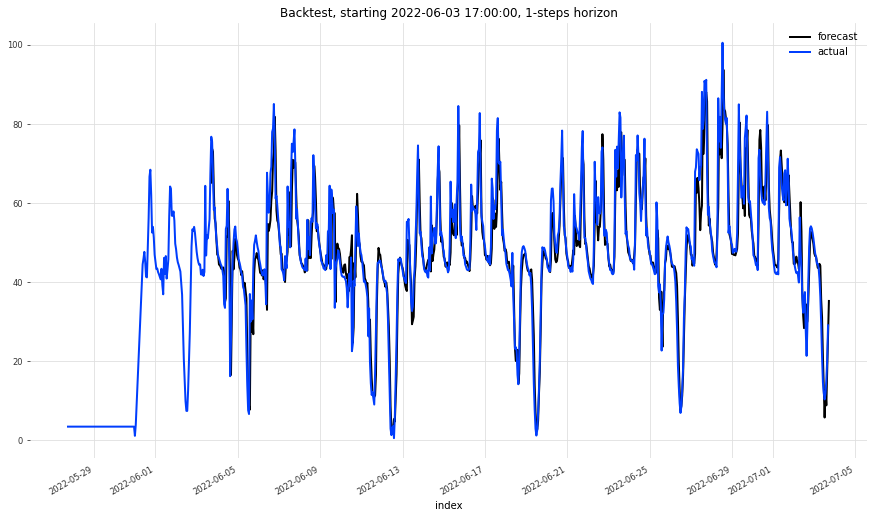

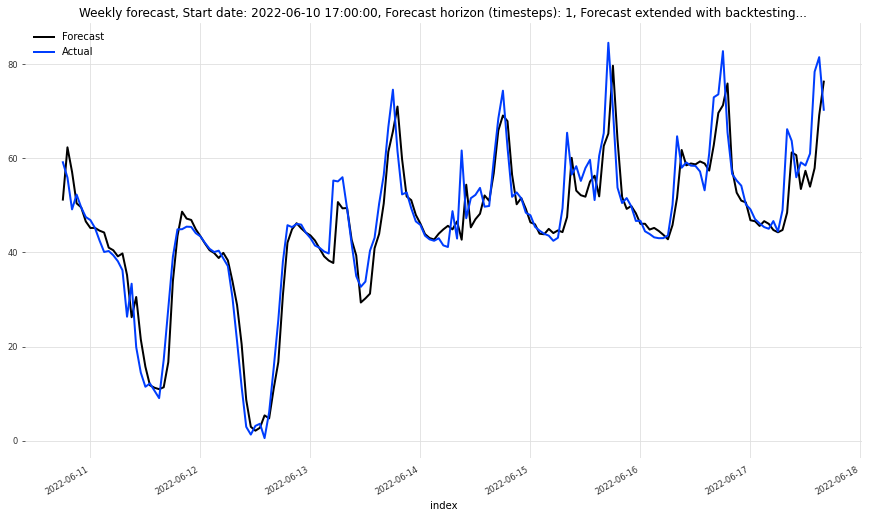

In [359]:
backtest_dict = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler )

We get a MASE error of 0.85. As MASE is defined as MAE / MAE*(Naive)* this value means that the Darts Lightgbm model performs better at forecasting the values of W4 compared to the Naive forecast.
Also we get a mean absolute percentage error of 11.5% 

Saving the returns of the backtester function to variables in case we want to plot our data 

In [360]:
backtest_series = backtest_dict.get("backtest_series")

In [361]:
backtest_metrics = backtest_dict.get("metrics")

In [362]:
test_series = series.drop_before(pd.Timestamp(pd.Timestamp(pd.Timestamp(
        '2022-06-03 17:00:00') - datetime.timedelta(hours=1))))

### Adding past and/or future covariates to LightGBM


We will use the weather data and the datetime attribute as covariates

Firstly we are going to convert the weather data to timeseries

In [363]:
weather_rad=convert_to_timeseries(weather,'global radiation [W/m^2]','60min')
weather_humidity = convert_to_timeseries(weather,'relative humidity [%]','60min')
weather_temp = convert_to_timeseries(weather,'air temperature [°C]','60min')
weather_cloud = convert_to_timeseries(weather,'cloudcover [%]','60min')
weather_wind = convert_to_timeseries(weather,'wind speed[m/s]','60min')


We will take the hour of the day and month attributes and convert them to Timeseries

In [364]:
hour_covariate = convert_to_timeseries(power,['hour_of_day'],'60min')
month_covariate = convert_to_timeseries(power,['month'],'60min')

####Light GBM Model with past covariates

Using the stack function to add multiple timeseries as past covariates

In [374]:
past_covariates =weather_temp.stack(hour_covariate).stack(weather_rad)

##### Splitting our past covariates to train, validation series

In [375]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(past_covariates,'2022-06-03 17:00:00')


We choose 7 * 24 lags as the lookback window and 1 day as lags for the past covariates.


smape :  9.744432850959072
mase :  0.8340104390054075
mae :  4.073645269533201
rmse :  6.376467527276777
mse :  40.65933812641521
mape :  11.443152157254985


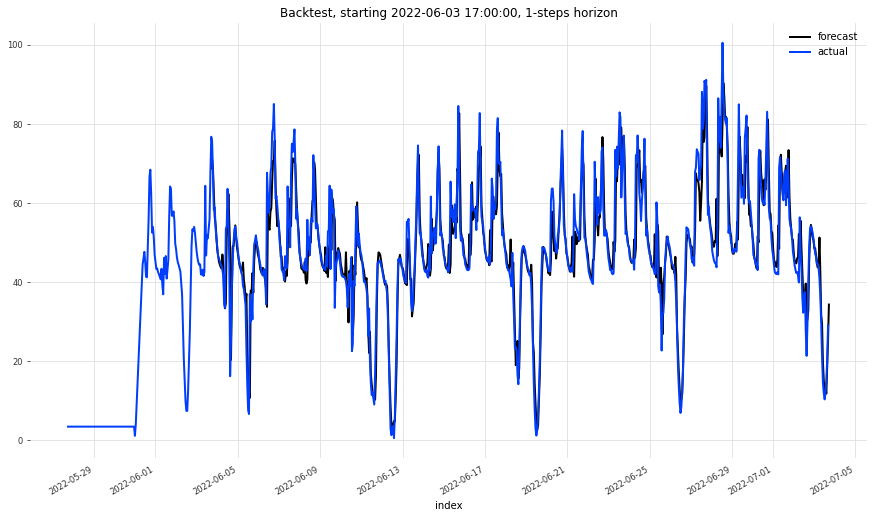

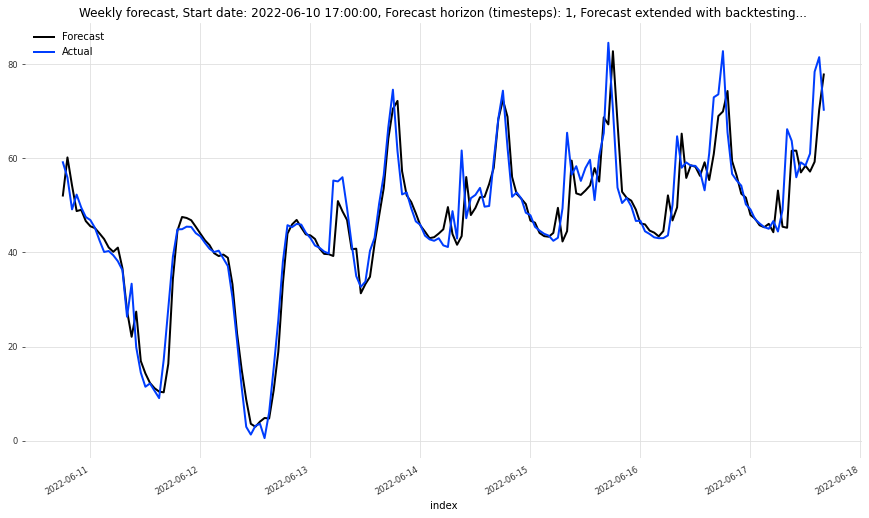

In [376]:
lgbm_model = LightGBMModel(lags = 7*24, lags_past_covariates = 1*24)
lgbm_model.fit(train, past_covariates = train_cov)
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, past_covariates=series_cov)

We notice that the model performs slightly better with the addition of the past covariates as mase drops to 0.83 and mape to 11.44%

####Light GBM Model with future covariates

Using the stack function to add multiple timeseries as future covariates

In [377]:
future_covariates =(weather_temp).stack(hour_covariate).stack(weather_rad)

##### Splitting our future covariates to train, validation series

In [378]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(future_covariates,'2022-06-03 17:00:00')


#####Train and predict

We will use as lags for the covariates used as past covariates 1*24 while for the future covariates we will take 1 lag to train our model

In [379]:
lgbm_model = LightGBMModel(lags = 7*24, lags_future_covariates = [1*24,1])
lgbm_model.fit(train, future_covariates = series_cov)


smape :  9.521856948393944
mase :  0.8181966117595662
mae :  3.996404122971461
rmse :  6.233399443435723
mse :  38.855268621424784
mape :  11.000715433907933


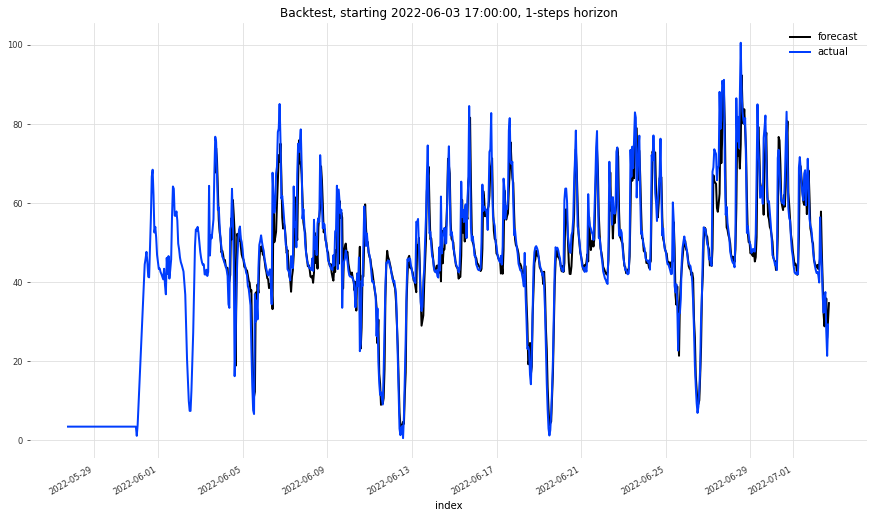

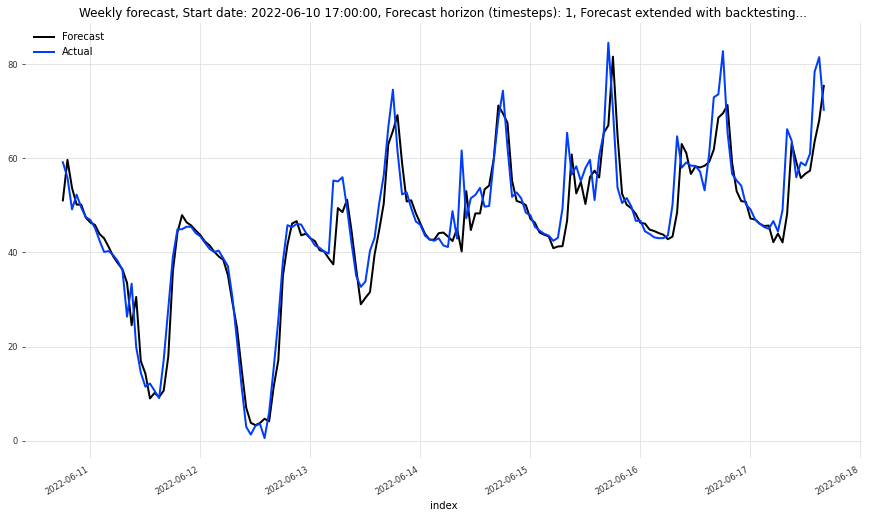

In [380]:
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, future_covariates=series_cov)

We notice that the model performs even better with the furure covariates than with the past covariates. Mape now drops to 11% from 11.5% and mase to 0.818 to 0.832

###Manual creation of dataframe used for historical forecasts

In order to check the validity of the forecasts made with historical_forecasts from Darts Library, we are going to manually test it, using sklearn library's forecasting models and metrics.

In [381]:
test_df = series.pd_dataframe()

By calling the feature_target_split function we split our series to a dataset containing the feature- target values based on the lookback_window and the forecast_horizon

In [382]:
X , Y = feature_target_split(test_df,test_df.columns[0],lookback_window=7*24)

Spliting dataset to x_train, x_test, y_train and y_test

In [383]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.09062303335431088735053492762744, random_state=42)

Defining the model, training it and predicting

In [384]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

In [385]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [386]:
model = lgb.train(params,train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l2: 577.046	valid_0's l1: 18.35
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 479.204	valid_0's l1: 16.7178
[3]	valid_0's l2: 399.096	valid_0's l1: 15.2717
[4]	valid_0's l2: 333.674	valid_0's l1: 13.9712
[5]	valid_0's l2: 279.822	valid_0's l1: 12.8114
[6]	valid_0's l2: 236.063	valid_0's l1: 11.7776
[7]	valid_0's l2: 200.704	valid_0's l1: 10.8417
[8]	valid_0's l2: 171.642	valid_0's l1: 10.0204
[9]	valid_0's l2: 148.18	valid_0's l1: 9.31991
[10]	valid_0's l2: 128.725	valid_0's l1: 8.67811
[11]	valid_0's l2: 112.675	valid_0's l1: 8.11605
[12]	valid_0's l2: 99.8634	valid_0's l1: 7.63978
[13]	valid_0's l2: 89.1614	valid_0's l1: 7.22526
[14]	valid_0's l2: 80.577	valid_0's l1: 6.85814
[15]	valid_0's l2: 73.0956	valid_0's l1: 6.52087
[16]	valid_0's l2: 67.1885	valid_0's l1: 6.24125
[17]	valid_0's l2: 61.955	valid_0's l1: 5.978
[18]	valid_0's l2: 57.6816	valid_0's l1: 5.76353
[19]	valid_0's l2: 

In [387]:
y_pred = model.predict(x_test)


Checking model's performance by gathering useful metrics

In [388]:
eval_model(y_test,y_pred)

mse :  29.964348055652138
rmse :  5.473970045191345
mape :  0.2555203877251993
mae :  3.6778947428964957


<Figure size 1080x360 with 0 Axes>

###Comparing Sklearn with Darts model performance

**Darts Metrics**

mse :  39.87661611055463

rmse :  6.314793433720111

mape :  11.508438291964119

mae :  4.158803484572047


**Sklearn's Metrics**

mse :  29.964348055652138
rmse :  5.473970045191345
mape :  0.2555203877251993
mae :  3.6778947428964957

As we see, by comparing the two models' metrics in terms of mape the darts model works better while the other metrics are higher for dart's model. -> This needs investigation

##Forecasting of the PV meter's active power (W6)


###Creating the train/validation Timeseries

We are going to repeat the procedure used before

#####Converting our dataframe to TimeSeries

As we have seen W6's active power is negative ( generating) and falls to zero- ish at night. Because our metrics and models work better with non zero values we are going to set all the values that are >-1 equal to 1.

In [392]:
power.at[power['active_w6']>-1,'active_w6']=1

We convert the part of the dataframe that concerns us, now the active power measured at the meter connected to the PV to Timeseries, with 60 minutes resolution.

In [393]:
series = convert_to_timeseries(power,['active_w6'],'60min')
series=abs(series) 

#####Spliting series to train and validation series 


We will split our series to train and validation ones, by calling the custom split_and scale function, giving as a parameter the date when we want to start the testing. We start by not giving our function a scaler, as we want to test our model with non-scaled data.

As we have 11 months of data we choose to keep the 10 months for training and the one month left for validating.

In [394]:
train, val, series_transformed, scaler = split_and_scale(series, '2022-06-03 17:00:00')

### LighGBM Model without past/ covariates


First we will try the LightGBM Model without any past or future covariates and check its performance

##### Train the model and predict 

After trying many values, we choose 5 days ( 5 x 24 observations) as the lookback window. (lags = 5*24)

In [459]:
lgbm_model = LightGBMModel(lags = 5*24)
lgbm_model.fit(train)


After fitting and training the model with our data we use the backtester_final function to make historical forecasts.

This method uses an expanding training window; it repeatedly builds a training set from the beginning of series. It trains the model on the training set, emits a forecast of length equal to forecast_horizon - here one hour - and then moves the end of the training set forward by stride time steps.


smape :  16.154863139616303
mase :  0.5457914189529942
mae :  4.771273506461919
rmse :  9.726688238852004
mse :  94.6084640958219
mape :  22.387103241597494


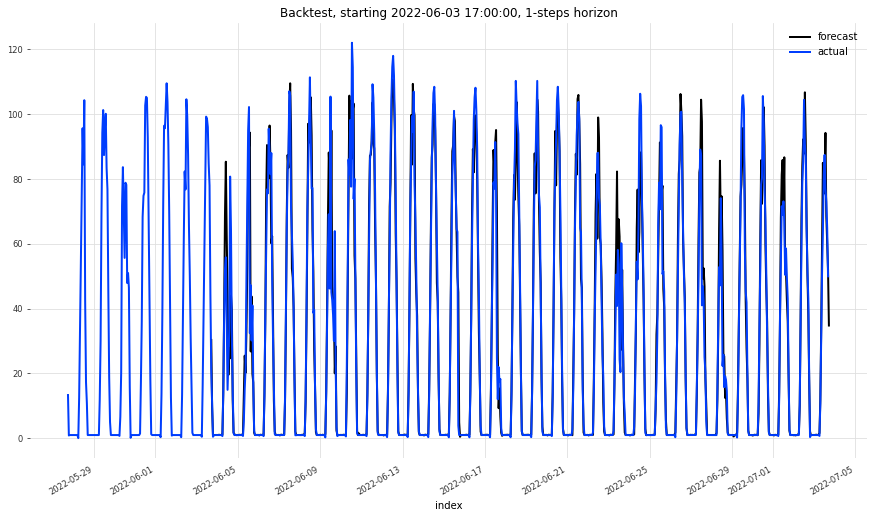

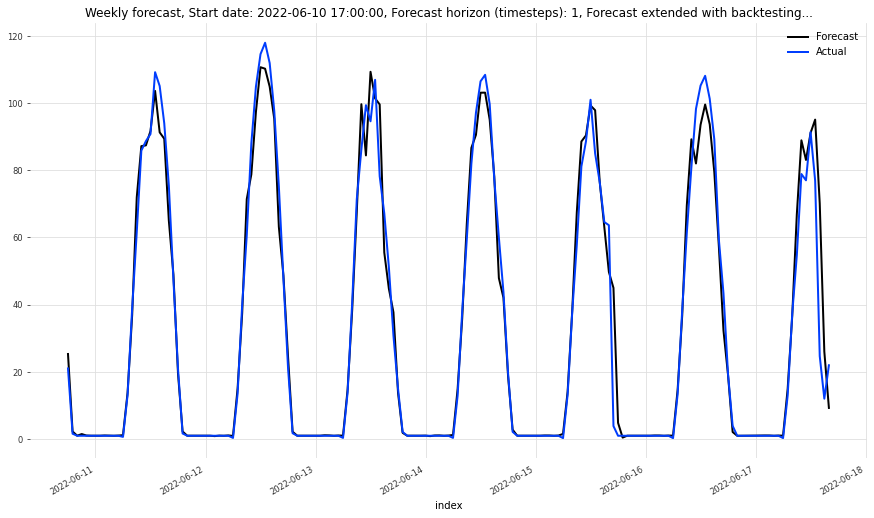

In [460]:
backtest_dict = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler )

We get a MASE error of 0.544. As MASE is defined as MAE / MAE*(Naive)* this value means that the Darts Lightgbm model performs much better at forecasting the values of W6's active power compared to the Naive forecast.
Also we get a mean absolute percentage error of 21.3% which is relatively high.

Saving the returns of the backtester function to variables in case we want to plot our data 

In [397]:
backtest_series = backtest_dict.get("backtest_series")

In [398]:
backtest_metrics = backtest_dict.get("metrics")

In [399]:
test_series = series.drop_before(pd.Timestamp(pd.Timestamp(pd.Timestamp(
        '2022-06-03 17:00:00') - datetime.timedelta(hours=1))))

### Adding past and/or future covariates


We will use the weather data and the datetime attribute as covariates

Firstly we are going to convert the weather data to timeseries

In [400]:
weather_rad=convert_to_timeseries(weather,'global radiation [W/m^2]','60min')
weather_humidity = convert_to_timeseries(weather,'relative humidity [%]','60min')
weather_temp = convert_to_timeseries(weather,'air temperature [°C]','60min')
weather_cloud = convert_to_timeseries(weather,'cloudcover [%]','60min')
weather_wind = convert_to_timeseries(weather,'wind speed[m/s]','60min')


We will take the hour of the day and month attributes and convert them to Timeseries

In [401]:
hour_covariate = convert_to_timeseries(power,['hour_of_day'],'60min')
month_covariate = convert_to_timeseries(power,['month'],'60min')

####Light GBM Model with past covariates

Using the stack function to add multiple timeseries as past covariates

In [461]:
past_covariates =weather_rad.stack(weather_temp).stack(weather_wind)

##### Splitting our past covariates to train, validation series

In [462]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(past_covariates,'2022-06-03 17:00:00')


We choose 7 * 24 lags as the lookback window and 1 day as lags for the past covariates.


smape :  20.108999666838166
mase :  0.5516013221589767
mae :  4.822063306886026
rmse :  9.619616631021978
mse :  92.53702412783464
mape :  37.59489028459649


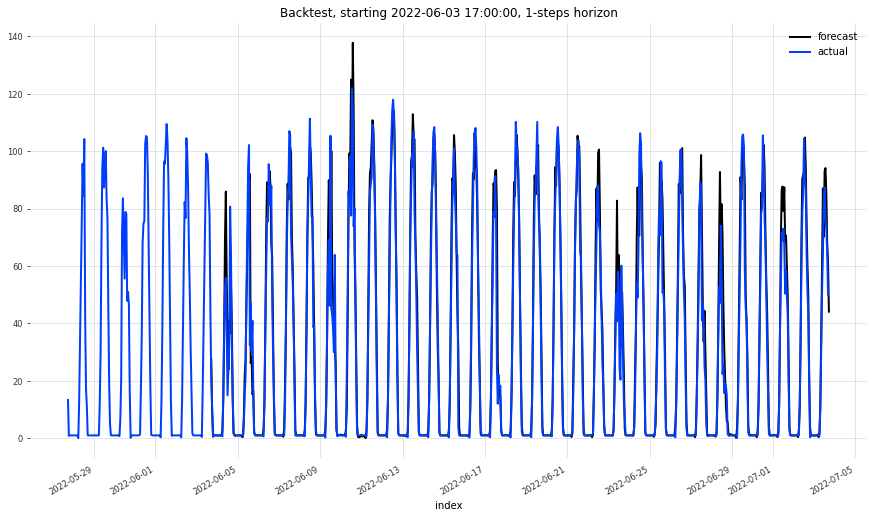

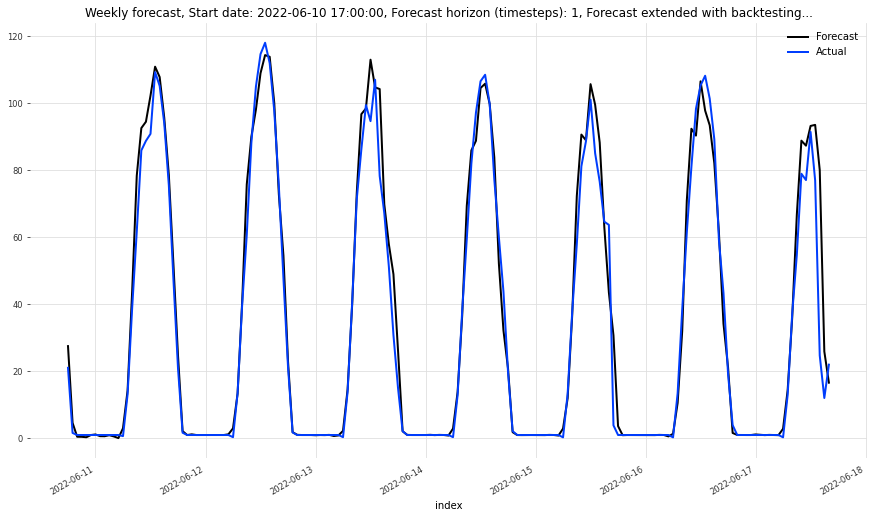

In [463]:
lgbm_model = LightGBMModel(lags = 5*24, lags_past_covariates = 24)
lgbm_model.fit(train, past_covariates = train_cov)
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, past_covariates=series_cov)

Oddly when adding weather data as past covariates the model performance gets worse.

We notice that the model performs slightly better with the addition of the hour attribute as past covariates.

In [464]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(hour_covariate,'2022-06-03 17:00:00')



smape :  16.783125436385962
mase :  0.5407277311592428
mae :  4.727007073212257
rmse :  9.686196090657171
mse :  93.82239470666228
mape :  20.97629265937026


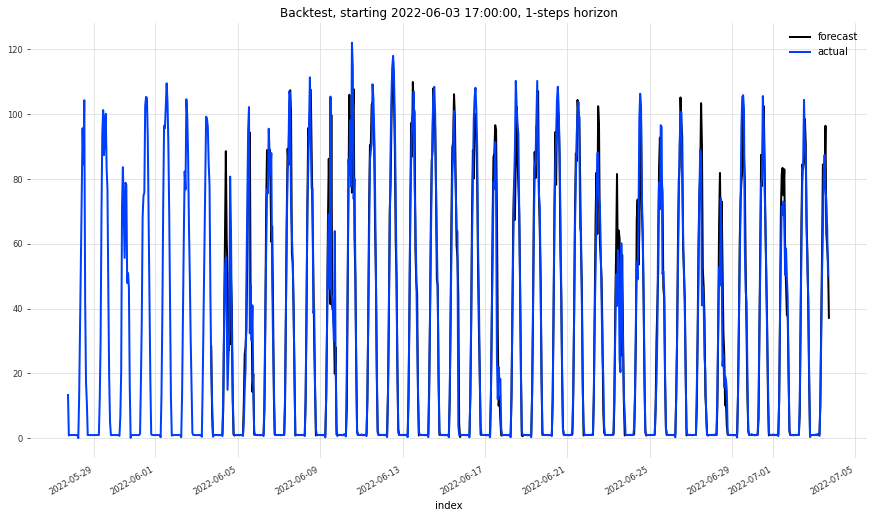

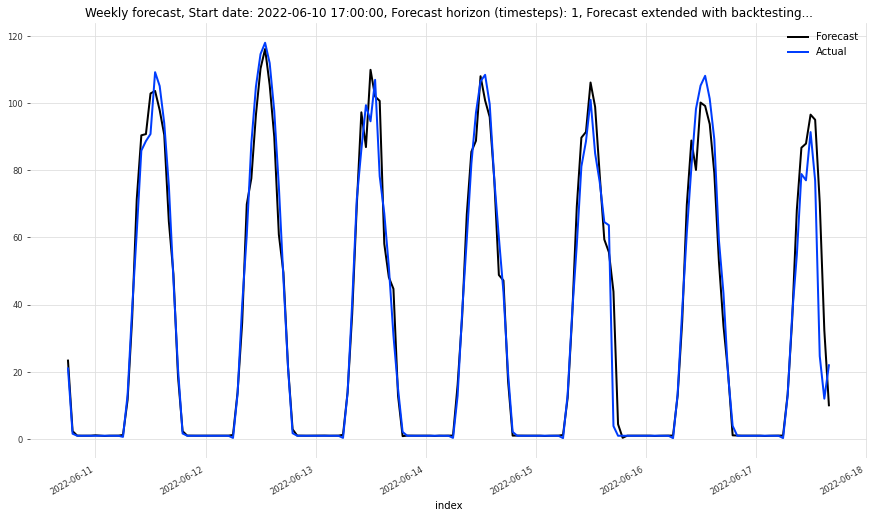

In [465]:
lgbm_model = LightGBMModel(lags = 5*24, lags_past_covariates = 24)
lgbm_model.fit(train, past_covariates = train_cov)
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, past_covariates=series_cov)

####Light GBM Model with future covariates

Using the stack function to add multiple timeseries as future covariates

In [449]:
future_covariates =(hour_covariate)

##### Splitting our future covariates to train, validation series

In [450]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(future_covariates,'2022-06-03 17:00:00')


#####Train and predict

We will use as lags for the covariates used as past covariates 1*24 while for the future covariates we will take 1 lag to train our model

In [451]:
lgbm_model = LightGBMModel(lags = 5*24, lags_future_covariates = [1*24,1])
lgbm_model.fit(train, future_covariates = series_cov)


smape :  16.20333793562673
mase :  0.5445820876772941
mae :  4.760701610173493
rmse :  9.786987392252472
mse :  95.78512221610883
mape :  21.309539638645784


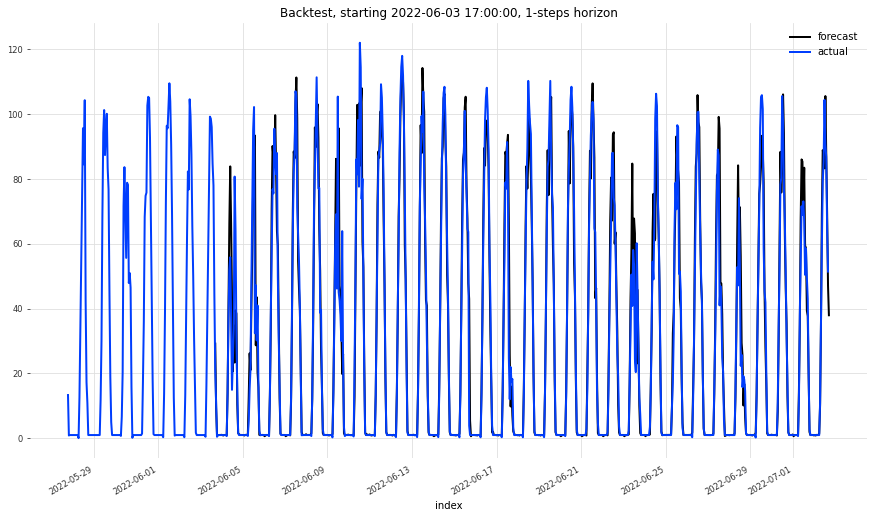

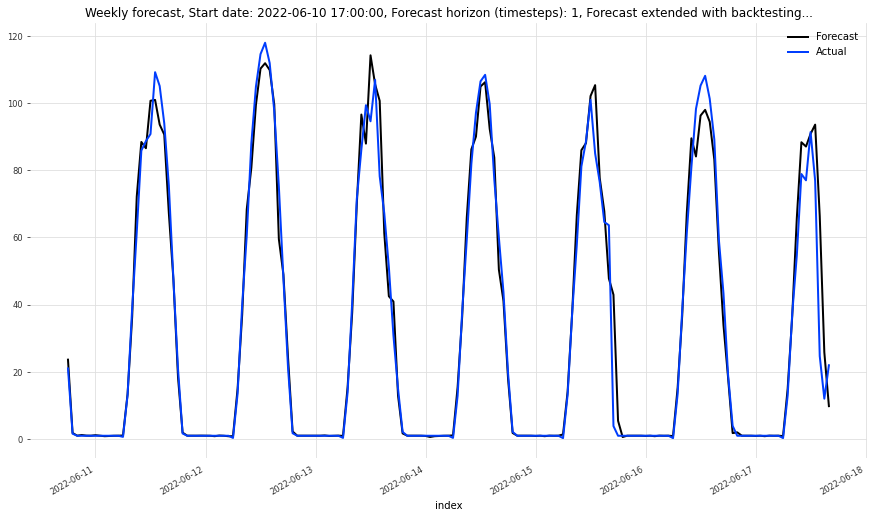

In [452]:
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, future_covariates=series_cov)

We notice that the model doesn't perform when adding the future covariates

###Manual creation of dataframe used for historical forecasts

In order to check the validity of the forecasts made with historical_forecasts from Darts Library, we are going to manually test it, using sklearn library's forecasting models and metrics.

In [466]:
test_df = series.pd_dataframe()

By calling the feature_target_split function we split our series to a dataset containing the feature- target values based on the lookback_window and the forecast_horizon

In [468]:
X , Y = feature_target_split(test_df,test_df.columns[0],lookback_window=5*24)

Spliting dataset to x_train, x_test, y_train and y_test

In [469]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.09062303335431088735053492762744, random_state=42)

Defining the model, training it and predicting

In [470]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

In [471]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [472]:
model = lgb.train(params,train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l2: 1254.39	valid_0's l1: 28.4839
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 1046.52	valid_0's l1: 25.9757
[3]	valid_0's l2: 875.563	valid_0's l1: 23.7274
[4]	valid_0's l2: 734.019	valid_0's l1: 21.6774
[5]	valid_0's l2: 620.872	valid_0's l1: 19.864
[6]	valid_0's l2: 527.558	valid_0's l1: 18.2311
[7]	valid_0's l2: 452.183	valid_0's l1: 16.7821
[8]	valid_0's l2: 390.117	valid_0's l1: 15.5059
[9]	valid_0's l2: 338.448	valid_0's l1: 14.341
[10]	valid_0's l2: 296.269	valid_0's l1: 13.2901
[11]	valid_0's l2: 262.749	valid_0's l1: 12.3667
[12]	valid_0's l2: 234.545	valid_0's l1: 11.5416
[13]	valid_0's l2: 211.321	valid_0's l1: 10.7986
[14]	valid_0's l2: 192.919	valid_0's l1: 10.1615
[15]	valid_0's l2: 176.664	valid_0's l1: 9.56843
[16]	valid_0's l2: 163.903	valid_0's l1: 9.05102
[17]	valid_0's l2: 152.144	valid_0's l1: 8.58073
[18]	valid_0's l2: 143.427	valid_0's l1: 8.18104
[19]	valid_0's

In [473]:
y_pred = model.predict(x_test)


Checking model's performance by gathering useful metrics

In [474]:
eval_model(y_test,y_pred)

mse :  94.23325249420996
rmse :  9.707381340722634
mape :  0.660341063738015
mae :  4.744190858736141


<Figure size 1080x360 with 0 Axes>

###Comparing Sklearn with Darts model performance

**Darts Metrics**

mse :  94.6084640958219

rmse :  9.726688238852004

mape :  22.387103241597494

mae :  4.771273506461919

**Sklearn's Metrics**
mse :  94.23325249420996

rmse :  9.707381340722634

mape :  0.660341063738015

mae :  4.744190858736141



By comparing the two models we see that MSE, RMSE and MAE are almost the same for both model while MAPE seems to be three times higher for the sklearn model. This need further investigation

##Forecasting of the PV meter's current (W6)


###Creating the train/validation Timeseries

We are going to repeat the procedure used before

#####Converting our dataframe to TimeSeries

We convert the part of the dataframe that concerns us, now the phase 1 of current measured at the meter connected to the PV to Timeseries, with 60 minutes resolution.

In [513]:
series = convert_to_timeseries(current,['w6_phase1'],'60min')
series=abs(series) 

#####Spliting series to train and validation series 


We will split our series to train and validation ones, by calling the custom split_and scale function, giving as a parameter the date when we want to start the testing. We start by not giving our function a scaler, as we want to test our model with non-scaled data.

As we have 11 months of data we choose to keep the 10 months for training and the one month left for validating.

In [514]:
train, val, series_transformed, scaler = split_and_scale(series, '2022-06-03 17:00:00')

### LighGBM Model without past/ covariates


First we will try the LightGBM Model without any past or future covariates and check its performance

##### Train the model and predict 

After trying many values, we choose 5 days ( 5 x 24 observations) as the lookback window. (lags = 5*24)

In [515]:
lgbm_model = LightGBMModel(lags = 5*24)
lgbm_model.fit(train)


After fitting and training the model with our data we use the backtester_final function to make historical forecasts.

This method uses an expanding training window; it repeatedly builds a training set from the beginning of series. It trains the model on the training set, emits a forecast of length equal to forecast_horizon - here one hour - and then moves the end of the training set forward by stride time steps.


smape :  12.147402643955441
mase :  0.5005006770229922
mae :  7.0176793698072695
rmse :  13.519056446763463
mse :  182.76488721077672
mape :  13.953193162198321


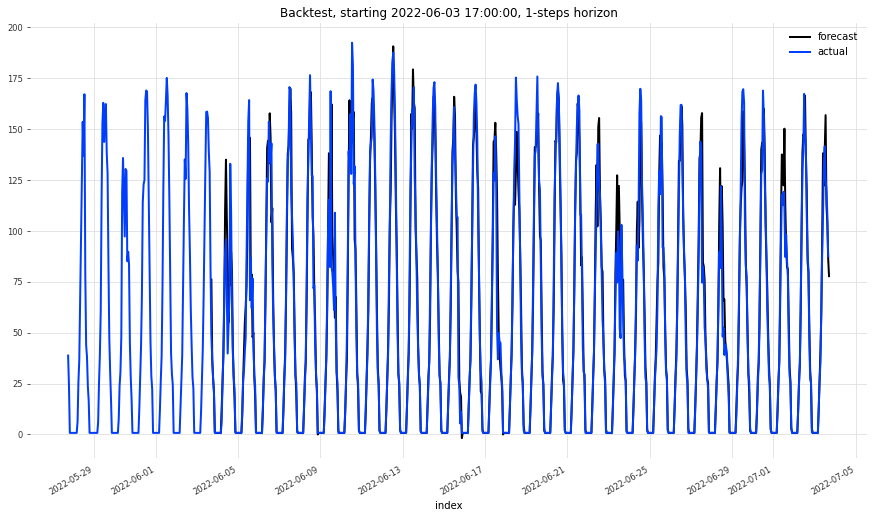

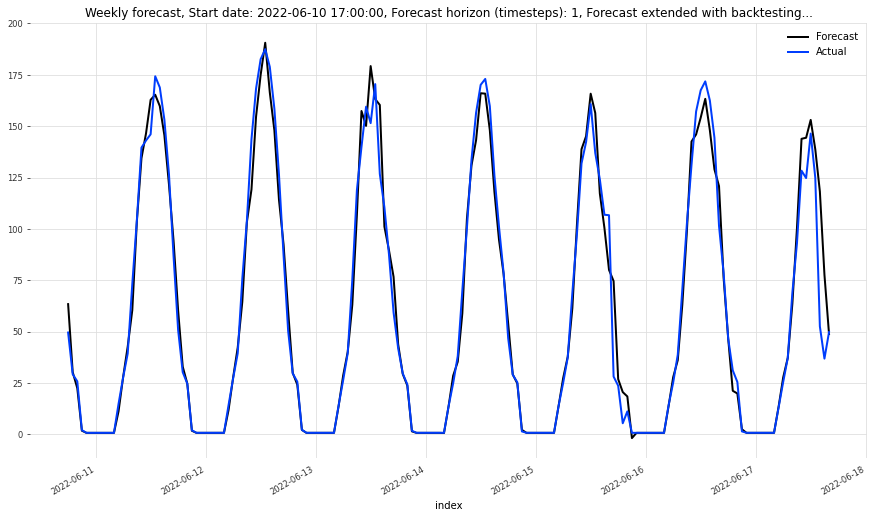

In [516]:
backtest_dict = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler )

We get a MASE error of 0.500. As MASE is defined as MAE / MAE*(Naive)* this value means that the Darts Lightgbm model performs much better at forecasting the values of W6's active power compared to the Naive forecast.
Also we get a mean absolute percentage error of 13.95% which is relatively high.

Saving the returns of the backtester function to variables in case we want to plot our data 

In [479]:
backtest_series = backtest_dict.get("backtest_series")

In [480]:
backtest_metrics = backtest_dict.get("metrics")

In [481]:
test_series = series.drop_before(pd.Timestamp(pd.Timestamp(pd.Timestamp(
        '2022-06-03 17:00:00') - datetime.timedelta(hours=1))))

### Adding past and/or future covariates


We will use the weather data and the datetime attribute as covariates

Firstly we are going to convert the weather data to timeseries

In [482]:
weather_rad=convert_to_timeseries(weather,'global radiation [W/m^2]','60min')
weather_humidity = convert_to_timeseries(weather,'relative humidity [%]','60min')
weather_temp = convert_to_timeseries(weather,'air temperature [°C]','60min')
weather_cloud = convert_to_timeseries(weather,'cloudcover [%]','60min')
weather_wind = convert_to_timeseries(weather,'wind speed[m/s]','60min')


We will take the hour of the day and month attributes and convert them to Timeseries

In [483]:
hour_covariate = convert_to_timeseries(power,['hour_of_day'],'60min')
month_covariate = convert_to_timeseries(power,['month'],'60min')

####Light GBM Model with past covariates

Using the stack function to add multiple timeseries as past covariates

In [487]:
past_covariates =weather_rad.stack(weather_temp).stack(hour_covariate)

##### Splitting our past covariates to train, validation series

In [488]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(past_covariates,'2022-06-03 17:00:00')


We choose 5 * 24 lags as the lookback window and 1 day as lags for the past covariates.


smape :  15.348448815063605
mase :  0.4910875392230087
mae :  6.8856947672348685
rmse :  13.113377234254283
mse :  171.9606624878585
mape :  18.072025871243778


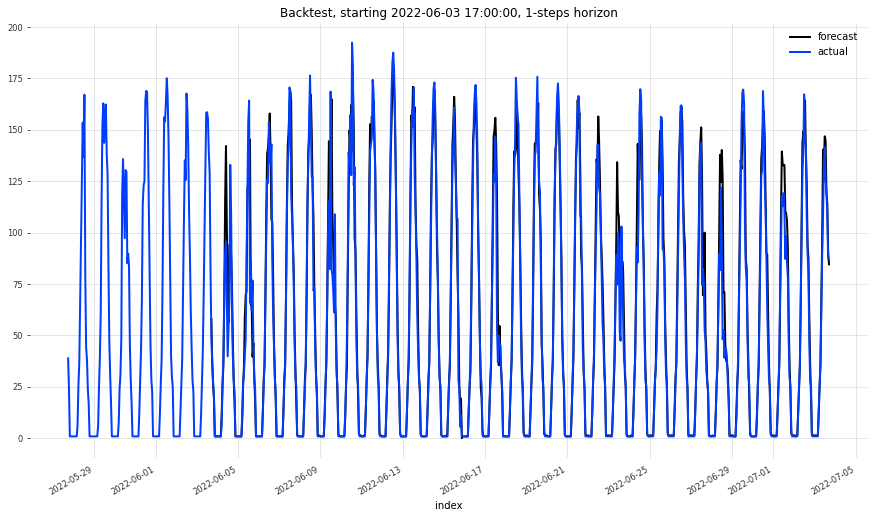

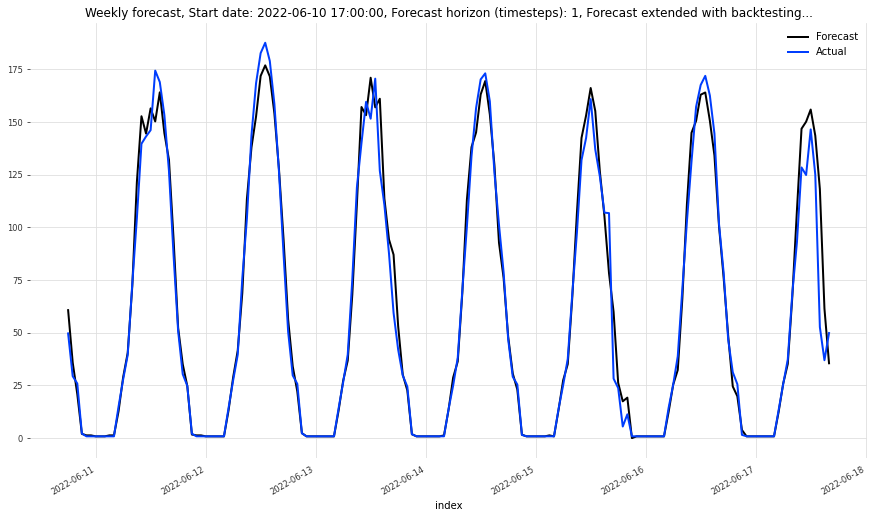

In [489]:
lgbm_model = LightGBMModel(lags = 5*24, lags_past_covariates = 24)
lgbm_model.fit(train, past_covariates = train_cov)
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, past_covariates=series_cov)

We notice that the model performs worse with the addition of the past covariates.

In [490]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(hour_covariate,'2022-06-03 17:00:00')



smape :  11.500496162531862
mase :  0.4965508462178975
mae :  6.962297534322022
rmse :  13.508279921409752
mse :  182.47362643516186
mape :  12.092269077481795


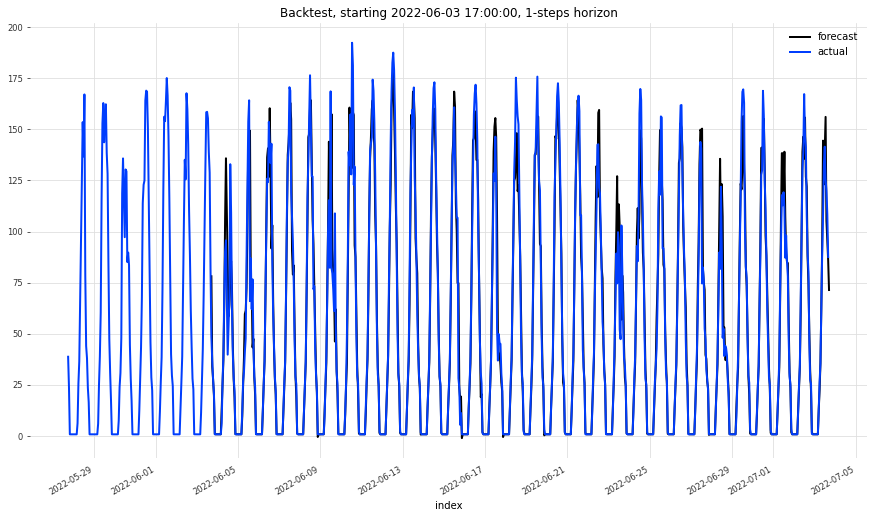

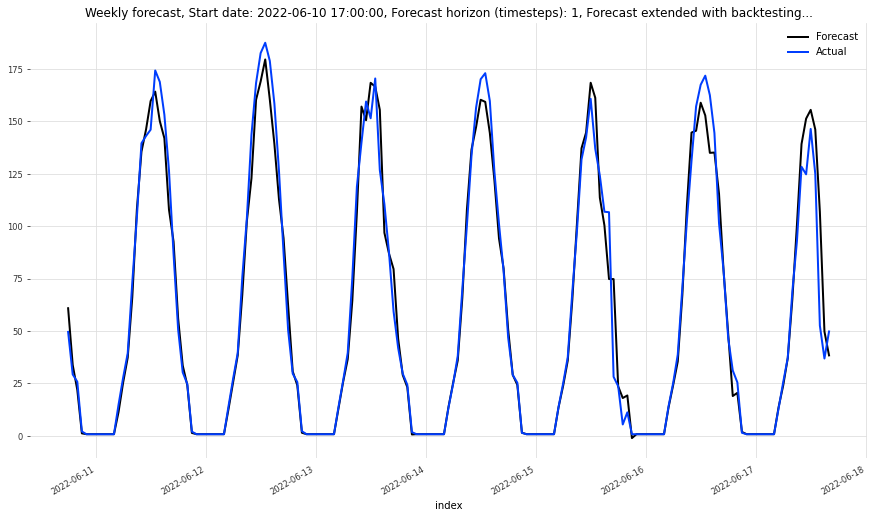

In [491]:
lgbm_model = LightGBMModel(lags = 5*24, lags_past_covariates = 24)
lgbm_model.fit(train, past_covariates = train_cov)
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, past_covariates=series_cov)

With the addition only of hours_covariate as past covariates we see that the model performs betters, with a Mase of 0.49 and MAPE of 12% from 13.5% that was before

####Light GBM Model with future covariates

Using the stack function to add multiple timeseries as future covariates

In [492]:
future_covariates =(hour_covariate)

##### Splitting our future covariates to train, validation series

In [493]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(future_covariates,'2022-06-03 17:00:00')


#####Train and predict

We will use as lags for the covariates used as past covariates 1*24 while for the future covariates we will take 1 lag to train our model

In [494]:
lgbm_model = LightGBMModel(lags = 5*24, lags_future_covariates = [1*24,1])
lgbm_model.fit(train, future_covariates = series_cov)


smape :  14.137977182460817
mase :  0.5173103242065068
mae :  7.253372785758572
rmse :  13.837212527488692
mse :  191.46845053089
mape :  15.569147151076312


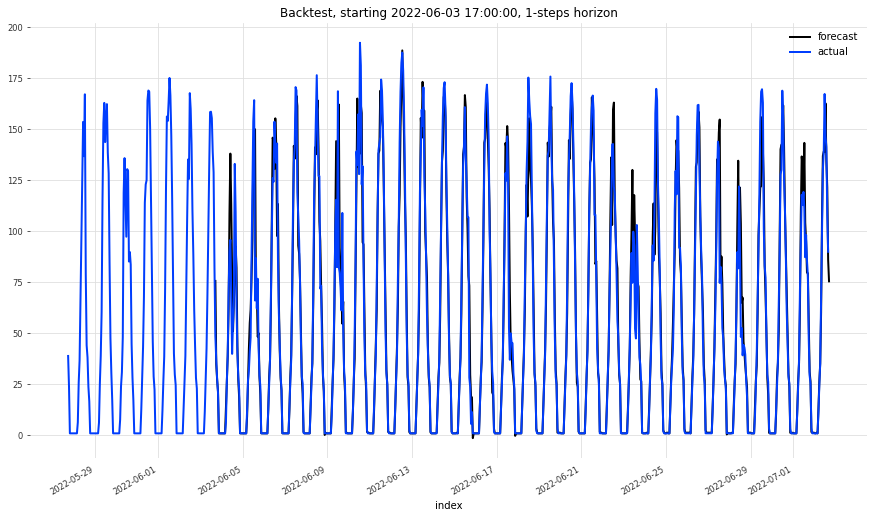

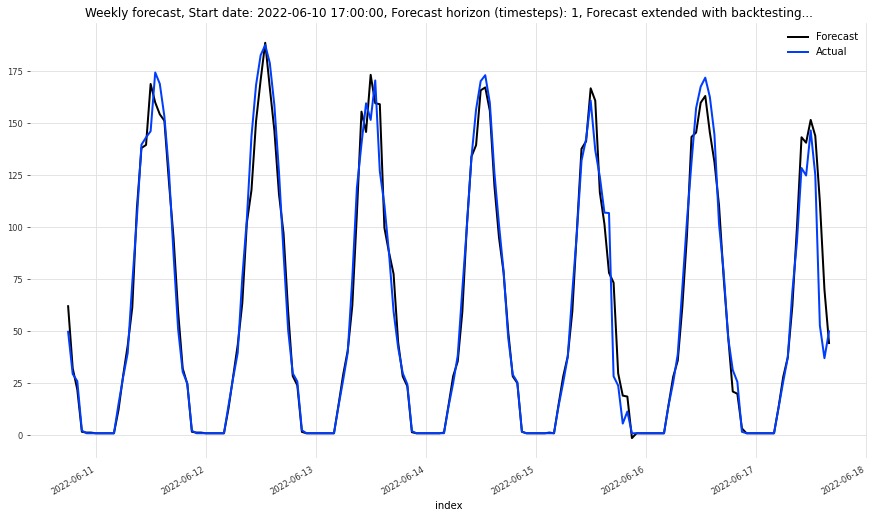

In [495]:
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,'2022-06-03 17:00:00',1, series=series,transformer_ts=scaler, future_covariates=series_cov)

We notice that the model performs worse when adding the future covariates

###Manual creation of dataframe used for historical forecasts

In order to check the validity of the forecasts made with historical_forecasts from Darts Library, we are going to manually test it, using sklearn library's forecasting models and metrics.

In [496]:
test_df = series.pd_dataframe()

By calling the feature_target_split function we split our series to a dataset containing the feature- target values based on the lookback_window and the forecast_horizon

In [497]:
X , Y = feature_target_split(test_df,test_df.columns[0],lookback_window=5*24)

Spliting dataset to x_train, x_test, y_train and y_test

In [498]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.09062303335431088735053492762744, random_state=42)

Defining the model, training it and predicting

In [499]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

In [500]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [501]:
model = lgb.train(params,train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l2: 3135.11	valid_0's l1: 45.2347
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 2608.2	valid_0's l1: 41.1296
[3]	valid_0's l2: 2171.97	valid_0's l1: 37.4623
[4]	valid_0's l2: 1809.67	valid_0's l1: 34.1337
[5]	valid_0's l2: 1520.25	valid_0's l1: 31.175
[6]	valid_0's l2: 1288.66	valid_0's l1: 28.583
[7]	valid_0's l2: 1091.23	valid_0's l1: 26.1976
[8]	valid_0's l2: 932.908	valid_0's l1: 24.08
[9]	valid_0's l2: 802.8	valid_0's l1: 22.2129
[10]	valid_0's l2: 694.909	valid_0's l1: 20.5473
[11]	valid_0's l2: 606.728	valid_0's l1: 19.0495
[12]	valid_0's l2: 534.509	valid_0's l1: 17.6749
[13]	valid_0's l2: 474.348	valid_0's l1: 16.4911
[14]	valid_0's l2: 425	valid_0's l1: 15.408
[15]	valid_0's l2: 384.924	valid_0's l1: 14.4757
[16]	valid_0's l2: 351.792	valid_0's l1: 13.6464
[17]	valid_0's l2: 323.858	valid_0's l1: 12.8902
[18]	valid_0's l2: 300.974	valid_0's l1: 12.23
[19]	valid_0's l2: 281.763

In [502]:
y_pred = model.predict(x_test)


Checking model's performance by gathering useful metrics

In [503]:
eval_model(y_test,y_pred)

mse :  185.91741828630836
rmse :  13.635153768341167
mape :  0.28795224330043145
mae :  6.923451945878587


<Figure size 1080x360 with 0 Axes>

###Comparing Sklearn with Darts model performance

**Darts Metrics**


mse :  182.76488721077672

rmse :  13.519056446763463

mape :  13.953193162198321

mae :  7.0176793698072695


**Sklearn's Metrics**

mse :  185.91741828630836

rmse :  13.635153768341167

mape :  0.28795224330043145

mae :  6.923451945878587



By comparing the two models we see again a big difference between the two MAPEs while the rest of the metrics are pretty close. 